Checking: LJ021-0144.pt
Mel Shape: (80, 753) | Range: [-8.11, 4.50]
✅ Duration Sum (753) matches Mel Length (753)


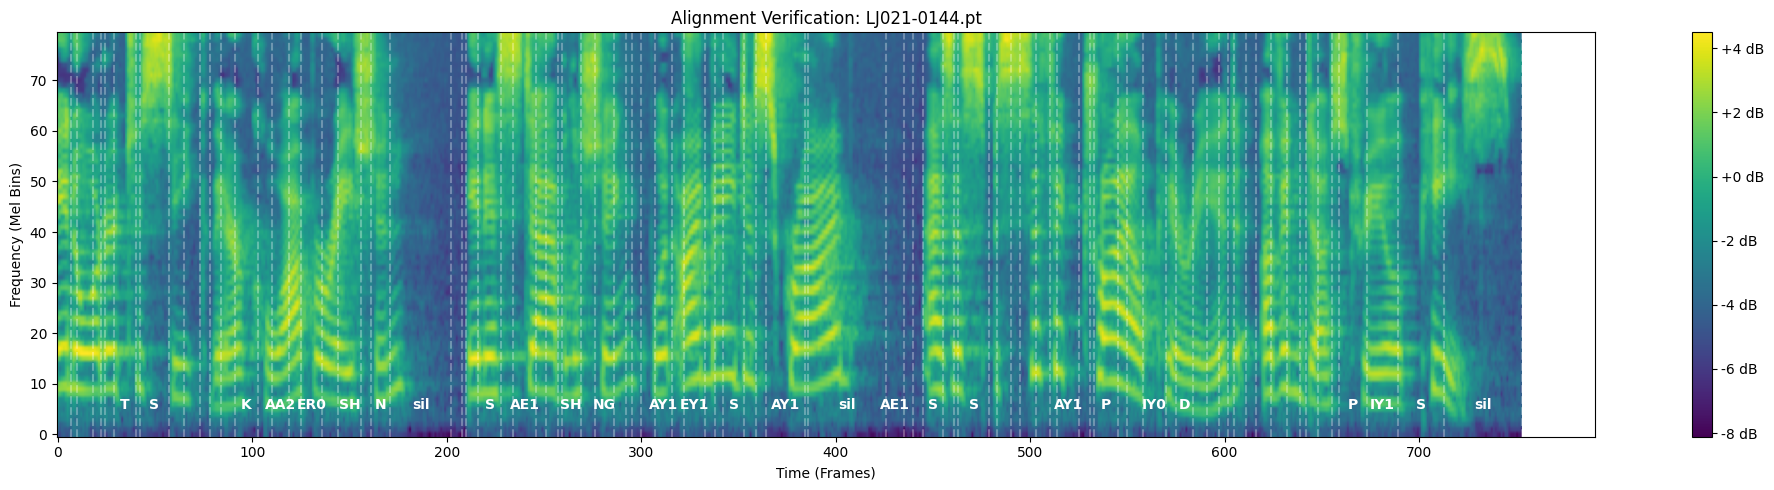

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from pathlib import Path

import os
import sys

# Add src to path for imports
sys.path.append('../src')

# Try to import your symbols. If this fails, make sure you are in the project root.
try:
    from src.symbols_new import id_to_symbol
except ImportError:
    # Fallback if running directly inside a notebook without src path
    from src.symbols import id_to_symbol

def verify_dataset(num_samples=1):
    processed_dir = Path("../data/processed")
    files = list(processed_dir.glob("*.pt"))
    
    if not files:
        print("No .pt files found in data/processed!")
        return

    # Pick random files
    samples = random.sample(files, num_samples)

    for file_path in samples:
        data = torch.load(file_path)
        
        mel = data["mel_spectrogram"].numpy()
        durations = data["durations"].numpy()
        phonemes = data["phonemes"].numpy()

        # --- CHECK 1: MATH ---
        total_dur = np.sum(durations)
        mel_len = mel.shape[1]
        
        print(f"Checking: {file_path.name}")
        print(f"Mel Shape: {mel.shape} | Range: [{mel.min():.2f}, {mel.max():.2f}]")
        
        if total_dur == mel_len:
            print(f"✅ Duration Sum ({total_dur}) matches Mel Length ({mel_len})")
        else:
            print(f"❌ MISMATCH: Durations sum to {total_dur} but Mel is {mel_len}")

        # --- CHECK 2: VISUALIZATION ---
        plt.figure(figsize=(20, 5))
        
        # Plot Spectrogram (origin='lower' puts low freq at bottom)
        plt.imshow(mel, origin='lower', aspect='auto', cmap='viridis')
        
        # Overlay Phoneme Boundaries
        current_x = 0
        for i, (ph_id, dur) in enumerate(zip(phonemes, durations)):
            symbol = id_to_symbol[ph_id]
            
            # Draw boundary line
            plt.axvline(x=current_x + dur, color='white', alpha=0.3, linestyle='--')
            
            # Draw Label (only if duration is wide enough to read)
            if dur > 8: 
                plt.text(current_x + dur/2, 5, symbol, 
                         color='white', fontweight='bold', ha='center', fontsize=10, rotation=0)
            
            current_x += dur

        plt.title(f"Alignment Verification: {file_path.name}")
        plt.xlabel("Time (Frames)")
        plt.ylabel("Frequency (Mel Bins)")
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

# Run the verification
verify_dataset(1)

In [ ]:
print("Hello")